In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [67]:
#Cargamos el dataframe de ventas de los tres años
df= pd.read_csv("../output/ModelDataset.csv")
df.sort_values(by='Date', inplace=True)
cat_cols= ['Category', 'TipoTienda', 'DimensionesTienda', 'Ciudad']
num_cols=['venta','LocationId','LocationStockId','es_festivo','dia_semana',	'mes','sin_semana','cos_semana','sin_mes','cos_mes','ventas_lag1','ventas_lag7','ventas_rolling7']
#df_dummy = pd.get_dummies(df, columns=['Category','TipoTienda','DimensionesTienda','Ciudad'], drop_first=True)

In [68]:
#Definicion de train-test split
fecha_corte = '2024-12-31'
train = df[df['Date'] <= fecha_corte]
test = df[df['Date'] > fecha_corte]

# Variable objetivo principal: cantidad
train_clean = train.dropna(subset=num_cols + ['Quantity'])
X_train = train_clean[cat_cols+num_cols]
y_train = train_clean['Quantity']

test_clean = test.dropna(subset=num_cols + ['Quantity'])
X_test = test_clean[cat_cols+num_cols]
y_test = test_clean['Quantity']

Entrenando modelo Lasso...


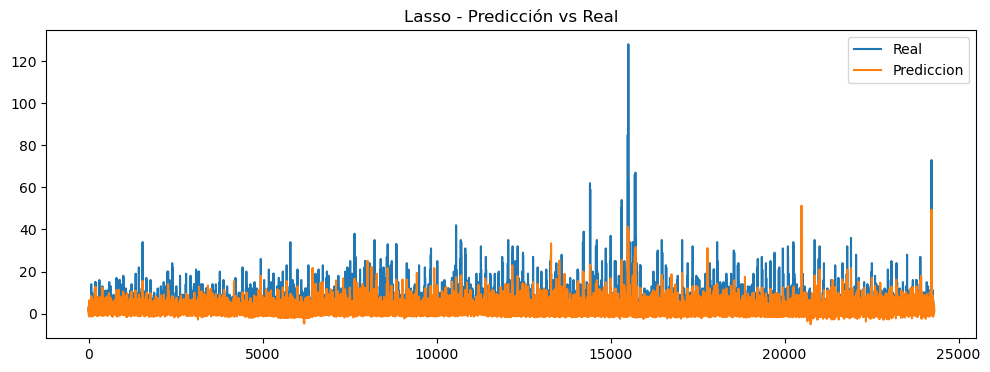

Entrenando modelo Ridge...


<Figure size 640x480 with 0 Axes>

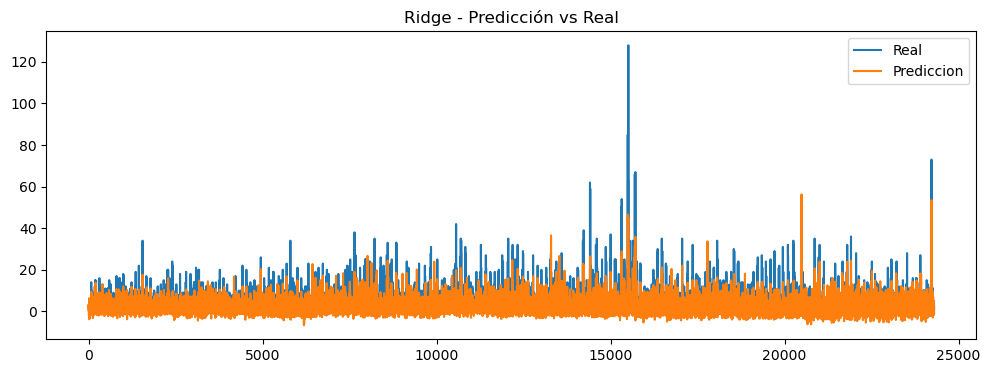

Entrenando modelo LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 73500, number of used features: 48
[LightGBM] [Info] Start training from score 2.906721


<Figure size 640x480 with 0 Axes>

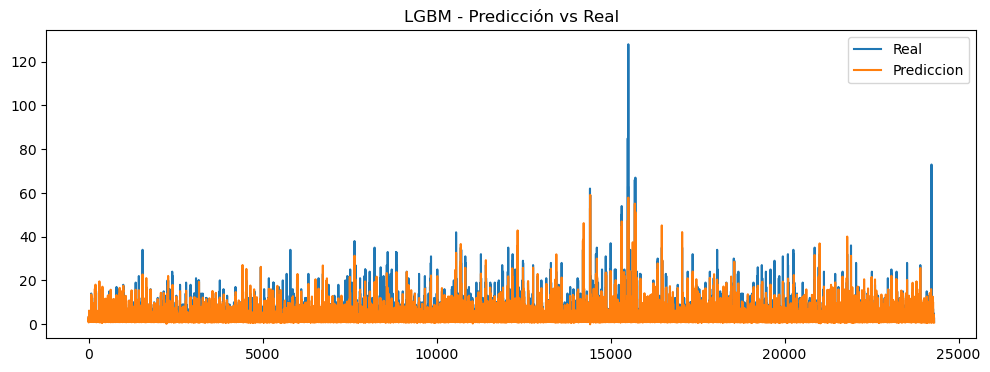

Entrenando modelo XGB...


<Figure size 640x480 with 0 Axes>

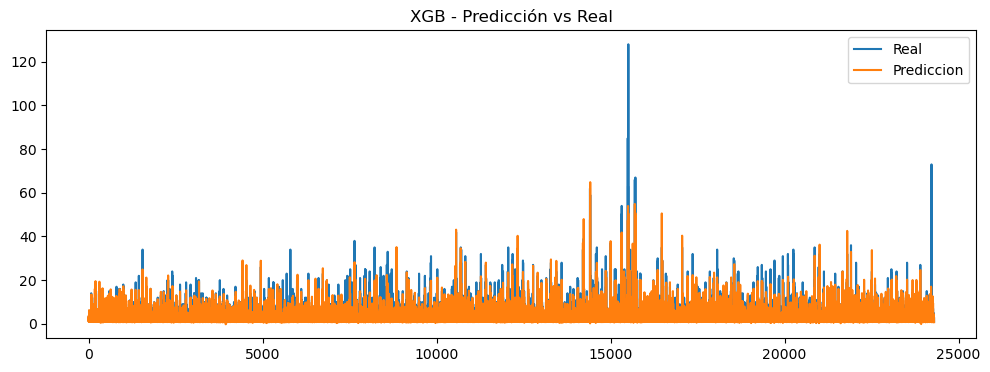

Entrenando modelo SARIMA...


<Figure size 640x480 with 0 Axes>

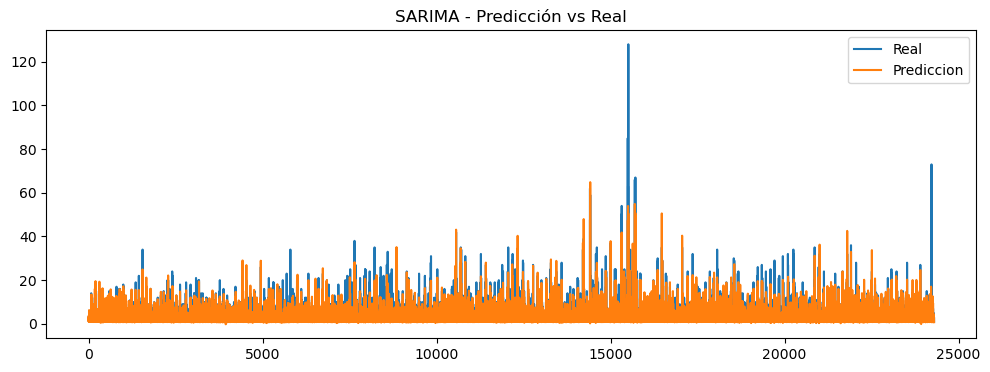

<Figure size 640x480 with 0 Axes>

In [69]:
# MODELADO
# =================

preprocessor=ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)
#Diccionario de modelos
models = {
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=1.0),
    'LGBM': LGBMRegressor(n_estimators=500, learning_rate=0.05),
    'XGB': XGBRegressor(n_estimators=500, learning_rate=0.05, objective='reg:squarederror'),
    'SARIMA': 'SARIMA'
}

results = {}
predicciones = {}
output_dir = "../output/images"
for name,model in models.items():
    print(f"Entrenando modelo {name}...")
    if name!= 'SARIMA':
        pipe=Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        trained_model = pipe 
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = {'MAPE': mape, 'RMSE': rmse, 'model': trained_model,'y_test': y_test,
            'y_pred': y_pred}
    else:
        y_train_sarima = y_train.copy()

        # Entrenar SARIMA
        sarima_model = SARIMAX(y_train_sarima,
                            order=(1,1,1),
                            seasonal_order=(1,1,1,7))
        sarima_result = sarima_model.fit(disp=False)

        # Predicciones sobre test (solo si quieres comparar con y_test)
        y_pred_sarima = sarima_result.get_prediction(start=y_test.index[0],
                                                    end=y_test.index[-1]).predicted_mean

        # 🔹 Alinear predicciones y valores reales
        y_test_aligned, y_pred_sarima = y_test.align(y_pred_sarima, join='inner')

        trained_model = sarima_result
        mape = mean_absolute_percentage_error(y_test_aligned, y_pred_sarima)
        rmse = np.sqrt(mean_squared_error(y_test_aligned, y_pred_sarima))
        results[name] = {'MAPE': mape, 'RMSE': rmse, 'model': trained_model,
                        'y_test': y_test_aligned, 'y_pred': y_pred_sarima}

    
    
    plt.figure(figsize=(12,4))
    plt.plot(y_test.values, label='Real')
    plt.plot(y_pred, label='Prediccion')
    plt.title(f"{name} - Predicción vs Real")
    plt.legend()
    plt.show()
    plt.savefig(f"../output/images/Prediccion_vs_Real({name}).png")

   Modelo      MAPE      RMSE  \
0   Lasso  0.923075  2.687531   
1   Ridge  1.035274  2.628096   
2    LGBM  0.294336  1.634652   
3     XGB   0.31227  1.660518   
4  SARIMA  0.806779  3.665634   

                                               model  \
0  (ColumnTransformer(transformers=[('num', Stand...   
1  (ColumnTransformer(transformers=[('num', Stand...   
2  (ColumnTransformer(transformers=[('num', Stand...   
3  (ColumnTransformer(transformers=[('num', Stand...   
4  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   

                                              y_test  \
0  73517    3
73510    2
73516    1
73515    3
73...   
1  73517    3
73510    2
73516    1
73515    3
73...   
2  73517    3
73510    2
73516    1
73515    3
73...   
3  73517    3
73510    2
73516    1
73515    3
73...   
4  73517    3
73590    2
73582    1
73589    1
73...   

                                              y_pred  
0  [2.4472793078831288, 1.9247382980863035, 0.368...  
1  [2.32385440986

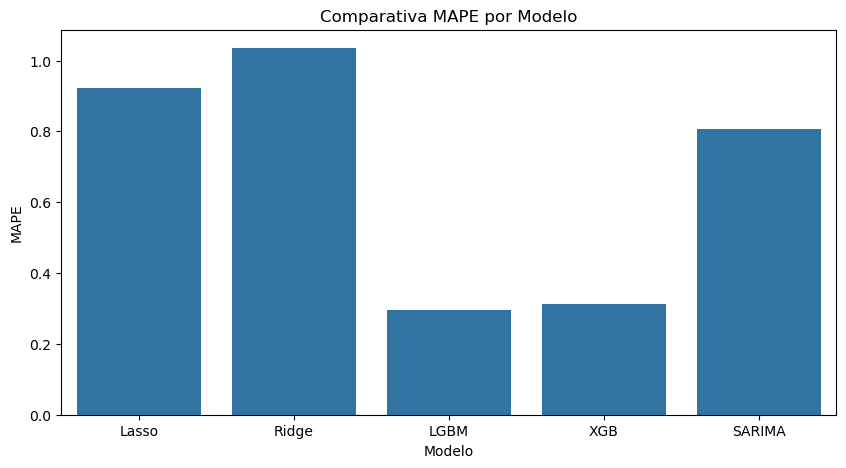

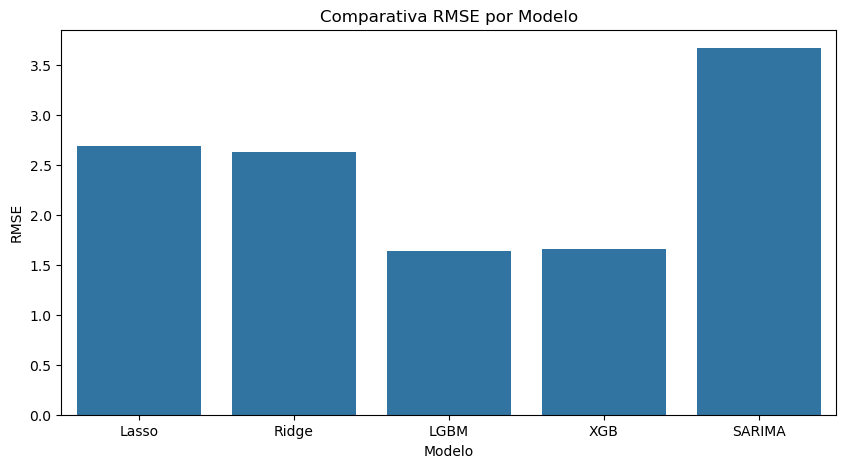

In [70]:
# 7. Comparativa de modelos
# ============================

metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.reset_index().rename(columns={'index':'Modelo'})
print(metrics_df)

# Gráficos comparativos
plt.figure(figsize=(10,5))
sns.barplot(x='Modelo', y='MAPE', data=metrics_df)
plt.title("Comparativa MAPE por Modelo")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='Modelo', y='RMSE', data=metrics_df)
plt.title("Comparativa RMSE por Modelo")
plt.show()

🏆 Mejor modelo: LGBM (MAPE=0.2943)

📊 Top 5 categorías con mejor predicción:
                   Category      MAPE
5                 LAVADORAS  0.157010
4               EMPOTRABLES  0.160184
7                 SECADORAS  0.164865
3              CONGELADORES  0.167064
6  REFRIGERADORES & NEVERAS  0.178434

📊 Top 5 categorías con peor predicción:
                   Category      MAPE
1                    COCINA  0.362408
0  ACONDICIONADORES DE AIRE  0.285480
8              VENTILADORES  0.276801
2       COCINAS & COCINETAS  0.245942
6  REFRIGERADORES & NEVERAS  0.178434


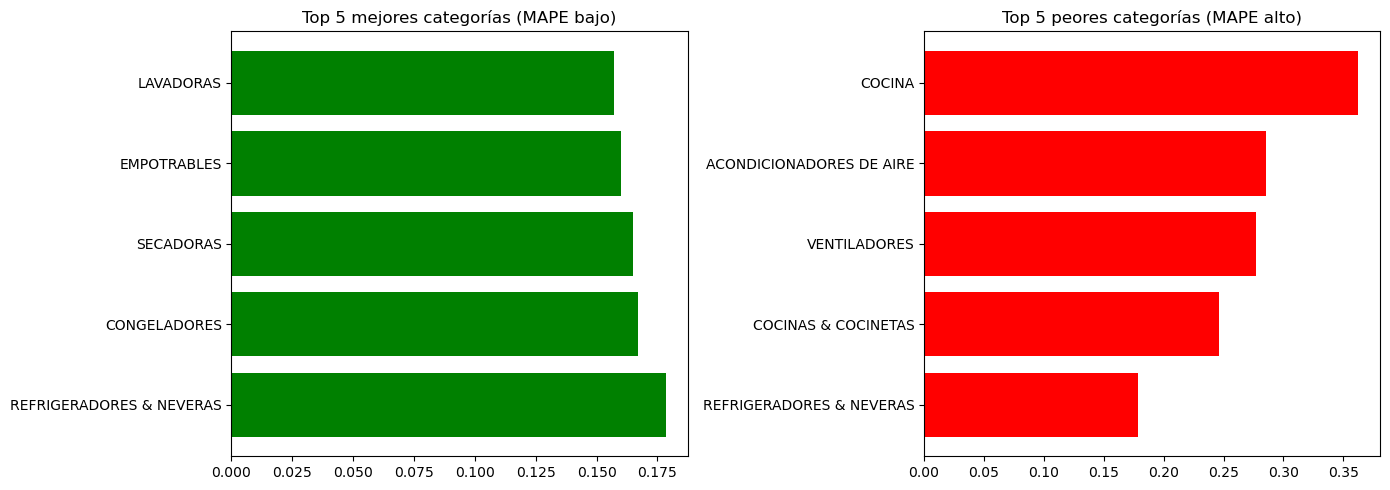


📊 Top 5 tiendas con mejor predicción:
    LocationId      MAPE
25        1558  0.219407
14        1537  0.232097
8         1525  0.239545
35        1613  0.244261
22        1553  0.245643

📊 Top 5 tiendas con peor predicción:
    LocationId      MAPE
50        1706  0.440500
49        1697  0.406246
0         1511  0.376909
28        1569  0.365440
16        1542  0.351052


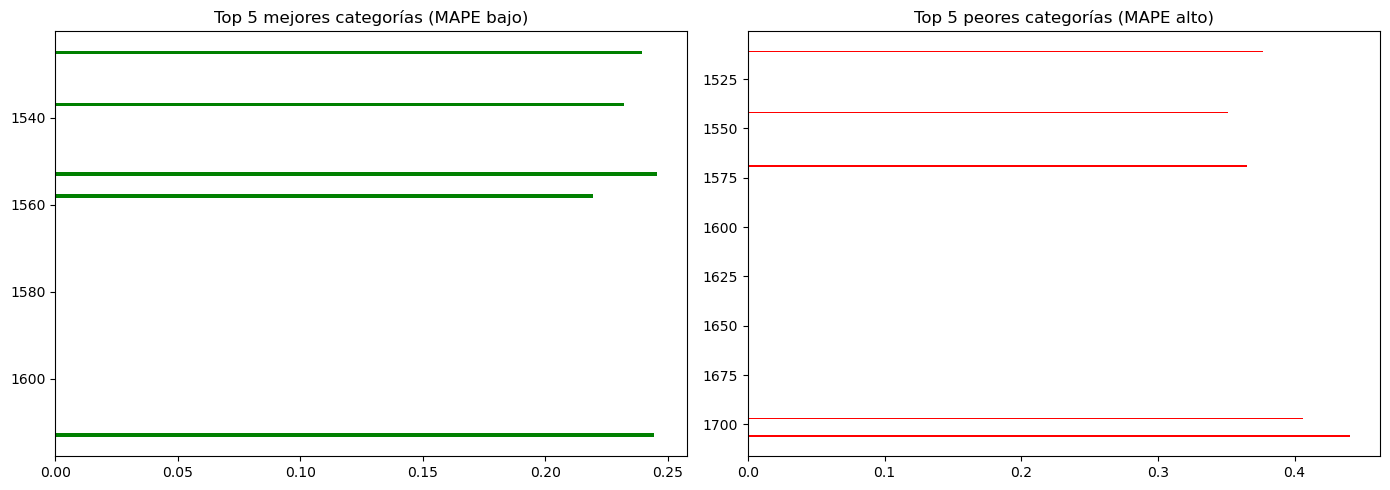

In [71]:
# 1️⃣ Seleccionar el mejor modelo por MAPE
best_model_name = min(results, key=lambda k: results[k]['MAPE'])
best_result = results[best_model_name]

print(f"🏆 Mejor modelo: {best_model_name} (MAPE={best_result['MAPE']:.4f})")

# 2️⃣ Unir con categorías
df_eval = pd.DataFrame({
    'Category': X_test.loc[best_result['y_test'].index, 'Category'],
    'y_true': best_result['y_test'],
    'y_pred': best_result['y_pred']
})
df_eval2 = pd.DataFrame({
    'LocationId': X_test.loc[best_result['y_test'].index, 'LocationId'],
    'y_true': best_result['y_test'],
    'y_pred': best_result['y_pred']
})

# 3️⃣ Calcular MAPE por categoría
mape_by_cat = df_eval.groupby('Category').apply(
    lambda g: mean_absolute_percentage_error(g['y_true'], g['y_pred'])
).reset_index(name='MAPE')
mape_by_tienda = df_eval2.groupby('LocationId').apply(
    lambda g: mean_absolute_percentage_error(g['y_true'], g['y_pred'])
).reset_index(name='MAPE')

# 4️⃣ Top 5 mejores y peores
top5_best = mape_by_cat.nsmallest(5, 'MAPE')
top5_worst = mape_by_cat.nlargest(5, 'MAPE')

print("\n📊 Top 5 categorías con mejor predicción:")
print(top5_best)

print("\n📊 Top 5 categorías con peor predicción:")
print(top5_worst)

# 5️⃣ Graficar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(top5_best['Category'], top5_best['MAPE'], color='green')
axes[0].set_title('Top 5 mejores categorías (MAPE bajo)')
axes[0].invert_yaxis()

axes[1].barh(top5_worst['Category'], top5_worst['MAPE'], color='red')
axes[1].set_title('Top 5 peores categorías (MAPE alto)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# 4️⃣ Top 5 mejores y peores
top5_best2 = mape_by_tienda.nsmallest(5, 'MAPE')
top5_worst2 = mape_by_tienda.nlargest(5, 'MAPE')

print("\n📊 Top 5 tiendas con mejor predicción:")
print(top5_best2)

print("\n📊 Top 5 tiendas con peor predicción:")
print(top5_worst2)

# 5️⃣ Graficar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(top5_best2['LocationId'], top5_best2['MAPE'], color='green')
axes[0].set_title('Top 5 mejores categorías (MAPE bajo)')
axes[0].invert_yaxis()

axes[1].barh(top5_worst2['LocationId'], top5_worst2['MAPE'], color='red')
axes[1].set_title('Top 5 peores categorías (MAPE alto)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [72]:

from typing import Iterable, Optional, Dict, Tuple

# --- Helpers cíclicos ---
def _sin_cos(idx: pd.Index, period_getter, prefix: str) -> pd.DataFrame:
    """
    period_getter: función que recibe idx y devuelve enteros en [0, period-1]
    """
    vals = period_getter(idx).astype(int)
    period = vals.max() + 1  # se asume cobertura completa del rango
    angle = 2 * np.pi * vals / period
    return pd.DataFrame({
        f"{prefix}_sin": np.sin(angle).astype(float),
        f"{prefix}_cos": np.cos(angle).astype(float),
    }, index=idx)

# --- Generador de features futuras con lags/rolling recursivos ---
def generar_features_futura(
    fechas: pd.DatetimeIndex,
    *,
    # contexto estático (por SKU/local/serie)
    Category: str,
    TipoTienda: str,
    DimensionesTienda: str,
    Ciudad: str,
    LocationId: int,
    LocationStockId: int,
    # serie histórica con índice datetime y valores de ventas
    y_hist: pd.Series | pd.DataFrame,
    # feriados opcionales
    feriados: Optional[Iterable[pd.Timestamp]] = None,
    # cómo rellenar 'venta' futura (feature)
    set_venta_as: str = "lag1"  # "lag1" | "nan"
) -> pd.DataFrame:
    """
    Devuelve un DataFrame con EXACTAMENTE las columnas de entrenamiento (cat_cols + num_cols),
    dejando NaN SOLO en 'venta', 'ventas_lag1', 'ventas_lag7', 'ventas_rolling7'.
    El relleno real de lags lo hará pronosticar_3m_lgbm de forma recursiva.
    """
    # --- fechas ---
    if not isinstance(fechas, pd.DatetimeIndex):
        fechas = pd.DatetimeIndex(fechas)

    # --- y_hist -> Serie unidimensional numérica con DatetimeIndex, sin duplicados ---
    if isinstance(y_hist, pd.DataFrame):
        if "venta" in y_hist.columns:
            y_hist = y_hist["venta"]
        elif "Quantity" in y_hist.columns:
            y_hist = y_hist["Quantity"]
        elif y_hist.shape[1] == 1:
            y_hist = y_hist.iloc[:, 0]
        else:
            raise ValueError("Si pasas DataFrame en y_hist, debe tener SOLO la columna de ventas (p.ej. 'venta' o 'Quantity').")

    y_hist = pd.Series(y_hist).dropna()
    if not isinstance(y_hist.index, pd.DatetimeIndex):
        y_hist.index = pd.to_datetime(y_hist.index, errors="raise")

    if y_hist.index.duplicated().any():
        y_hist = y_hist.groupby(level=0).sum()

    y_hist = y_hist.sort_index().astype(float)

    # --- Base de calendario ---
    df = pd.DataFrame(index=fechas)
    df.index.name = "date"
    df["dia_semana"] = df.index.dayofweek.astype(int)  # 0..6
    df["mes"]        = df.index.month.astype(int)      # 1..12

    # Cíclicos
    df["sin_semana"] = np.sin(2 * np.pi * (df["dia_semana"] / 7.0)).astype(float)
    df["cos_semana"] = np.cos(2 * np.pi * (df["dia_semana"] / 7.0)).astype(float)
    df["sin_mes"]    = np.sin(2 * np.pi * ((df["mes"] - 1) / 12.0)).astype(float)
    df["cos_mes"]    = np.cos(2 * np.pi * ((df["mes"] - 1) / 12.0)).astype(float)

    # Feriados
    if feriados is not None:
        feriados_idx = pd.DatetimeIndex(pd.to_datetime(list(feriados)))
        df["es_festivo"] = df.index.isin(feriados_idx).astype(int)
    else:
        df["es_festivo"] = 0

    # Estáticos / categóricos (forzar string para que OHE no vea NaN)
    df["Category"]          = str(Category)
    df["TipoTienda"]        = str(TipoTienda)
    df["DimensionesTienda"] = str(DimensionesTienda)
    df["Ciudad"]            = str(Ciudad)

    # IDs / numéricos base (sin NaN)
    df["LocationId"]      = float(LocationId)
    df["LocationStockId"] = float(LocationStockId)

    # Placeholders de lags/rolling y 'venta' futura (se rellenan en el loop recursivo)
    df["ventas_lag1"]     = np.nan
    df["ventas_lag7"]     = np.nan
    df["ventas_rolling7"] = np.nan
    df["venta"] = np.nan  # se rellenará con lag1 si set_venta_as == "lag1" en el loop

    # Orden EXACTO como tus listas de entrenamiento
    ordered_cols = (
        ['Category','TipoTienda','DimensionesTienda','Ciudad'] +
        ['venta','LocationId','LocationStockId','es_festivo','dia_semana','mes',
         'sin_semana','cos_semana','sin_mes','cos_mes','ventas_lag1','ventas_lag7','ventas_rolling7']
    )
    df = df[ordered_cols]

    # Guardar attrs para el loop recursivo
    df.attrs["y_hist"] = y_hist
    df.attrs["set_venta_as"] = set_venta_as

    # Sanity: NO debe haber NaN salvo en lags/venta
    base_cols = ['LocationId','LocationStockId','es_festivo','dia_semana','mes','sin_semana','cos_semana','sin_mes','cos_mes']
    if df[base_cols].isna().any().any():
        raise ValueError("Hay NaN en columnas base numéricas. Revisa IDs/calendario/feriados.")

    for c in ['Category','TipoTienda','DimensionesTienda','Ciudad']:
        if df[c].isna().any():
            raise ValueError(f"Hay NaN en columna categórica {c}.")

    return df


def pronosticar_3m_lgbm(model, df_future: pd.DataFrame, *, fallback_when_empty: float = 0.0) -> Tuple[pd.Series, pd.DataFrame]:
    # --- y_hist seguro ---
    y_hist = df_future.attrs.get("y_hist", None)
    if y_hist is None:
        raise ValueError("df_future debe venir de generar_features_futura (incluye attrs['y_hist']).")
    if isinstance(y_hist, pd.DataFrame):
        if "venta" in y_hist.columns: y_hist = y_hist["venta"]
        elif "Quantity" in y_hist.columns: y_hist = y_hist["Quantity"]
        elif y_hist.shape[1] == 1: y_hist = y_hist.iloc[:, 0]
        else: raise ValueError("y_hist DataFrame con múltiples columnas; especifica la de ventas.")
    y_hist = pd.Series(y_hist).dropna()
    if not isinstance(y_hist.index, pd.DatetimeIndex):
        y_hist.index = pd.to_datetime(y_hist.index, errors="raise")
    if y_hist.index.duplicated().any():
        y_hist = y_hist.groupby(level=0).sum()
    y_hist = y_hist.sort_index().astype(float)

    set_venta_as = df_future.attrs.get("set_venta_as", "lag1")
    if set_venta_as not in ("lag1", "nan"):
        set_venta_as = "lag1"

    cols = [
        'Category','TipoTienda','DimensionesTienda','Ciudad',
        'venta','LocationId','LocationStockId','es_festivo','dia_semana','mes',
        'sin_semana','cos_semana','sin_mes','cos_mes','ventas_lag1','ventas_lag7','ventas_rolling7'
    ]
    num_cols = ['venta','LocationId','LocationStockId','es_festivo','dia_semana','mes',
                'sin_semana','cos_semana','sin_mes','cos_mes','ventas_lag1','ventas_lag7','ventas_rolling7']
    cat_cols = ['Category','TipoTienda','DimensionesTienda','Ciudad']

    # Validación de columnas
    faltantes = [c for c in cols if c not in df_future.columns]
    if faltantes:
        raise ValueError(f"df_future no contiene columnas requeridas: {faltantes}")

    buffer = y_hist.copy()
    preds = []
    used_records = []   # <- acumulamos dicts (no DataFrames)
    used_index = []     # <- guardamos el índice (fechas) en paralelo

    for dt in df_future.index:
        # Tomamos 1 fila como DataFrame 1xN
        row_df = df_future.loc[[dt], cols].copy()

        # Categóricas a string
        for c in cat_cols:
            row_df[c] = row_df[c].astype(str)

        # Numéricas base a float
        row_df[['LocationId','LocationStockId','es_festivo','dia_semana','mes',
                'sin_semana','cos_semana','sin_mes','cos_mes']] = (
            row_df[['LocationId','LocationStockId','es_festivo','dia_semana','mes',
                    'sin_semana','cos_semana','sin_mes','cos_mes']]
            .apply(pd.to_numeric, errors="coerce")
            .astype(float)
        )

        # Lags (escalares)
        n = int(len(buffer))
        lag1 = float(buffer.iloc[-1]) if n >= 1 else float(fallback_when_empty)
        lag7 = float(buffer.iloc[-7]) if n >= 7 else (lag1 if n >= 1 else float(fallback_when_empty))
        rolling7 = float(buffer.iloc[-min(7, n):].mean()) if n >= 1 else float(fallback_when_empty)

        # Asignamos en la fila
        row_df.loc[dt, 'ventas_lag1']     = lag1
        row_df.loc[dt, 'ventas_lag7']     = lag7
        row_df.loc[dt, 'ventas_rolling7'] = rolling7
        row_df.loc[dt, 'venta']           = lag1 if set_venta_as == "lag1" else np.nan

        # Validación previa
        Xn = row_df[num_cols].to_numpy(dtype=float)
        if np.isnan(Xn).any() or np.isinf(Xn).any():
            raise ValueError(f"NaN/Inf en numéricas para {dt}. Valores:\n{row_df[num_cols]}")

        # Predicción con tu pipeline
        y_hat = float(model.predict(row_df[cols])[0])
        preds.append(y_hat)

        # Actualizar buffer
        buffer.loc[pd.Timestamp(dt)] = y_hat

        # Guardar registro usado como dict
        rec = row_df[cols].iloc[0].to_dict()
        rec['y_hat'] = y_hat
        used_records.append(rec)
        used_index.append(dt)

    # Construimos df_used SIN concat de DataFrames
    df_used = pd.DataFrame.from_records(used_records, index=pd.DatetimeIndex(used_index, name="date"))
    y_pred  = pd.Series(preds, index=df_future.index, name="y_pred")
    return y_pred, df_used


Total registros serie: 223
Registros históricos hasta 2025-07-31: 223
Rango histórico: 2023-01-02 00:00:00 → 2025-07-31 00:00:00
Date
2025-07-18    1.0
2025-07-24    1.0
2025-07-26    1.0
2025-07-27    1.0
2025-07-31    1.0
Name: Quantity, dtype: float64
<class 'pandas.core.frame.DataFrame'>
             Category TipoTienda DimensionesTienda   Ciudad  venta  \
date                                                                 
2025-08-01  LAVADORAS     TIENDA            GRANDE  MILAGRO    NaN   
2025-08-02  LAVADORAS     TIENDA            GRANDE  MILAGRO    NaN   
2025-08-03  LAVADORAS     TIENDA            GRANDE  MILAGRO    NaN   
2025-08-04  LAVADORAS     TIENDA            GRANDE  MILAGRO    NaN   
2025-08-05  LAVADORAS     TIENDA            GRANDE  MILAGRO    NaN   

            LocationId  LocationStockId  es_festivo  dia_semana  mes  \
date                                                                   
2025-08-01      1537.0           1537.0           0           4    8   


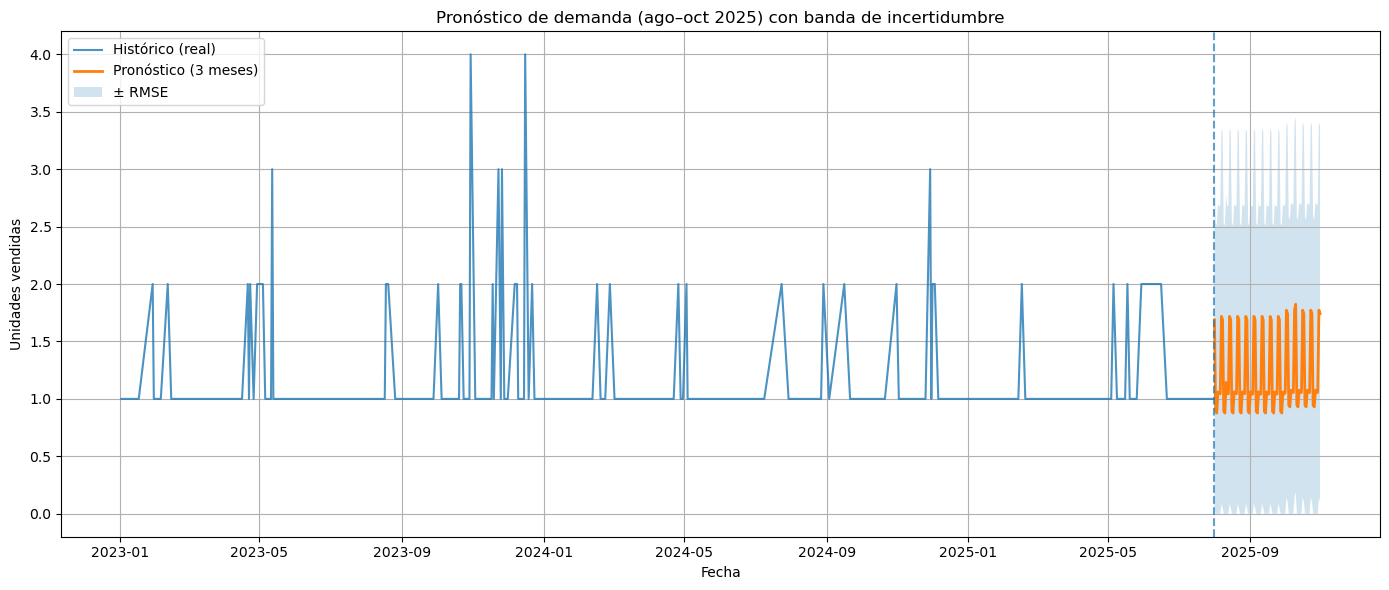

<Figure size 640x480 with 0 Axes>

In [73]:

# --- Parámetros clave ---
df["Date"] = pd.to_datetime(df["Date"])

# Filtra la serie específica
mask = (
    (df["Category"] == "LAVADORAS") &
    (df["Ciudad"] == "MILAGRO") &
    (df["LocationId"] == 1537) &
    (df["LocationStockId"] == 1537)
)
serie_df = df.loc[mask].sort_values("Date")

# Serie histórica hasta 31-jul-2025
mask_hist = serie_df["Date"] <= "2025-07-31"
y_hist = serie_df.loc[mask_hist, "Quantity"].astype(float)
y_hist.index = serie_df.loc[mask_hist, "Date"]
print("Total registros serie:", len(serie_df))
print("Registros históricos hasta 2025-07-31:", mask_hist.sum())
print("Rango histórico:", y_hist.index.min(), "→", y_hist.index.max())
print(y_hist.tail())
name = "lgbm"  # clave dentro de tu dict result
pipe = best_result["model"]   # pipeline: preprocessor + LGBM
rmse = best_result["RMSE"]

# Serie histórica (ventas) para la misma serie (SKU/local/etc.) con índice datetime
# Debe llegar hasta el 2025-07-31 para que el horizonte empiece el 2025-08-01
# Ejemplo:
# y_hist = ventas_series.loc[:'2025-07-31']  # <- Asegúrate que este índice es datetime

# Fechas a pronosticar: 1-ago-2025 a 31-oct-2025 (3 meses)
future_dates = pd.date_range(start="2025-08-01", end="2025-10-31", freq="D")
# --- Construcción de features futuras (ajusta valores estáticos a tu serie/tienda/sku) ---
df_future = generar_features_futura(
    future_dates,
    Category="LAVADORAS",
    TipoTienda="TIENDA",
    DimensionesTienda="GRANDE",
    Ciudad="MILAGRO",
    LocationId=1537,
    LocationStockId=1537,
    y_hist=y_hist,         # histórico hasta el 2025-07-31
    feriados=['2025-08-11','2025-10-10','2025-11-03','2025-11-04','2025-12-25'],         # o lista de feriados si los tienes
    set_venta_as="lag1",   # evita NaN para StandardScaler
)

# --- Predicción recursiva que respeta lags/rolling ---
print(type(df_future))
print(df_future.head())
def quick_nan_check(df):
    n = df.isna().sum()
    n = n[n>0].sort_values(ascending=False)
    print("NaNs por columna:\n", n if not n.empty else "Ninguno")

quick_nan_check(df_future) 
print("type(y_hist):", type(df_future.attrs["y_hist"]))
print("y_hist shape:", df_future.attrs["y_hist"].shape)
print("is DatetimeIndex:", isinstance(df_future.attrs["y_hist"].index, pd.DatetimeIndex))
print("dup idx?:", df_future.attrs["y_hist"].index.duplicated().any())
print(df_future.attrs["y_hist"].head())
y_future_pred, df_used = pronosticar_3m_lgbm(pipe, df_future)

# --- Banda de incertidumbre simple ±RMSE ---
lower = np.clip(y_future_pred - rmse, 0, None)
upper = y_future_pred + rmse

# --- (Opcional) histórico reciente a mostrar (tú decides ventana) ---
# Uso todo el y_hist; si prefieres últimos 12 meses, filtra aquí
hist_real = y_hist.copy()

# Si además quieres mostrar desempeño del modelo en holdout (si lo guardaste):
# y_test = result[name]["y_test"]
# y_pred = result[name]["y_pred"]

# --- Gráfico: histórico + pronóstico 3m desde 01-ago-2025 ---
plt.figure(figsize=(14,6))

# 1) Histórico real
plt.plot(hist_real.index, hist_real.values, label="Histórico (real)", alpha=0.8)

# 2) Pronóstico (línea central)
plt.plot(y_future_pred.index, y_future_pred.values, label="Pronóstico (3 meses)", linewidth=2)

# 3) Banda de incertidumbre (±RMSE)
plt.fill_between(y_future_pred.index, lower.values, upper.values, alpha=0.2, label="± RMSE")

# 4) Línea vertical que separa histórico y futuro
cutoff = pd.Timestamp("2025-08-01")
plt.axvline(cutoff, linestyle="--", alpha=0.7)

# Etiquetas y formato
plt.title("Pronóstico de demanda (ago–oct 2025) con banda de incertidumbre")
plt.xlabel("Fecha")
plt.ylabel("Unidades vendidas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(f"../output/images/Pronostico_3m_LGBM.png")
